In [1]:
%run ../aux_funcs.py
%run ../RSRG.py
%run ../RSRG_class.py
from iminuit import cost, Minuit
# faster than scipy.stats functions
from numba_stats import truncnorm, truncexpon, norm, expon
from scipy.stats import multivariate_normal as mvnorm

In [2]:

def linear_fit(x, m, b):
    return m*x+b

In [4]:
L = 40
steps = 1400
measure_step = 10

a_vals = np.array([0.1])#np.arange(0.05, 0.2, 0.02)
b_vals = np.array([0.105])#np.arange(0.1,0.3,0.03)

J_ij_vals, h_vals, R0_array, mu_array = run_decimation(L, steps, measure_step, a_vals, b_vals, track_moments=True)

/home/jebediah/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


[0.07293883 1.69131471]
0.14587765065835256


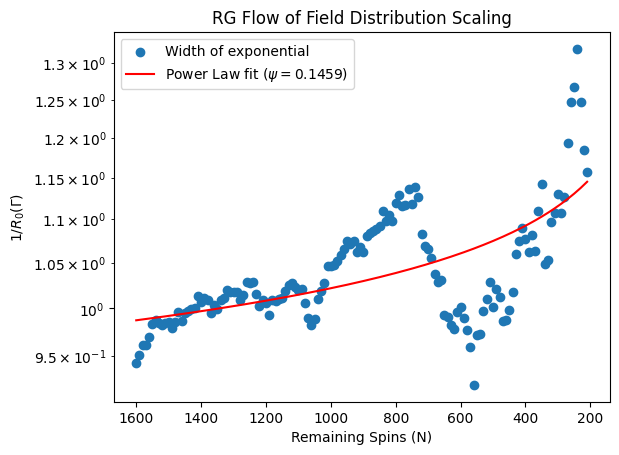

In [3]:
x = L*L - np.arange(len(R0_array))*measure_step
y = 1/np.array(R0_array)
R_length = len(y)

plt.scatter(x, y, label='Width of exponential')#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)
#plt.yscale('log')

popt, pcov = curve_fit(power_law_scale, x[int(R_length/2):], y[int(R_length/2):])
print(popt)
print(popt[0]*2)

plt.title("RG Flow of Field Distribution Scaling")
plt.xlabel("Remaining Spins (N)")
plt.ylabel(r"$1/R_0(\Gamma)$")
plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Power Law fit ($\psi=$'+str(round(popt[0]*2, 4))+')')

plt.gca().invert_xaxis()
plt.legend()
plt.yscale('log')
#plt.ylim(0, 1.5)

[-0.04419099  0.33309617]


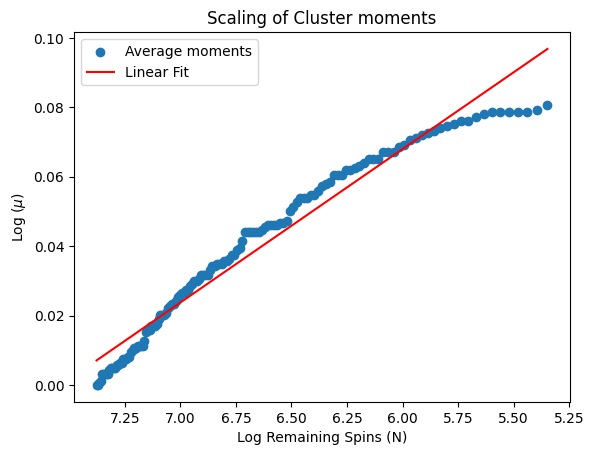

In [4]:
x = np.log(L*L - np.arange(len(R0_array))*measure_step)
y = np.log(mu_array)
R_length = len(y)

plt.scatter(x, y, label='Average moments')#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)
#plt.yscale('log')

popt, pcov = curve_fit(linear_fit, x[int(R_length/100):], y[int(R_length/100):])
print(popt)

plt.title("Scaling of Cluster moments")
plt.xlabel("Log Remaining Spins (N)")
plt.ylabel(r"Log $(\mu)$")
plt.plot(x, linear_fit(x, *popt), color='red', label=r'Linear Fit')

plt.gca().invert_xaxis()
plt.legend()

#plt.ylim(0, 1.5)

In [142]:
L = 60
steps = int(0.99*L*L)
a, b = 0.1, 0.105
measure_step = 30

ind_dict, adj_ind = triangle_lattice_dictionary(L)
nn_ind = triangle_nn_indices(L)
nnn_ind = triangle_nnn_indices(L)

measure_list = np.floor(steps*(1/(1.1**np.arange(1,60))))
measure_list = measure_list.astype(int)
check_list = np.floor(L*L*(1- 1/(1.6**np.arange(10))))

runs = 1

In [143]:
a_vals = np.array([0.02, 0.04, 0.06, 0.08, 0.1, 0.12])
b_vals = np.array([0.06])

a_list = np.zeros(shape=(len(a_vals), 1+int(steps/measure_step)))
b_list = np.zeros(shape=(len(b_vals), 1+int(steps/measure_step)))
R0_array = np.zeros(shape=(len(a_vals), 1+int(steps/measure_step)))

for run in range(runs):  
    for a_ind, a in enumerate(a_vals):
    #for b_ind, b in enumerate(b_vals):
        J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b)
        h_vals = np.exp(-np.random.exponential(size=L*L))
        test = system(L*L, adj_ind, J_ij_vals, h_vals)   

        for i in range(steps):
            test.decimate()
            if i%measure_step==0:  #(L*L-i) in measure_list:#
                ind = int(i/measure_step)#np.where(measure_list==(L*L-i))
                h_remain = test.h_vals
                h_remain = h_remain[h_remain!=0]

                c = cost.UnbinnedNLL(-np.log(h_remain/test.Omega), exponential_dist_norm)
                m = Minuit(c, a=0.8)
                m.migrad()
                R0_array[a_ind, ind] += m.values[0]
                #R0_array[b_ind, ind] += m.values[0]
                
                a_sc = a/9
                b_sc = b/9
                #print(i)
                J_remain = -np.log(sparse.find(test.J_ij_vals)[2])
                x = np.linspace(0, (np.sqrt(a_sc**2 + 2*b_sc) - a_sc)/b_sc, len(J_remain))

                n,bins = np.histogram(J_remain, density = 'True', bins=30)
                width = bins[1]-bins[0]
                popt, pcov = curve_fit(linDist, (bins[1:]-width/2), n)
                a_list[a_ind, ind] += popt[0]
                #b_list[b_ind, ind] += popt[1]
                #plt.plot(x, np.array(linDist(x, *popt)))
                """
                if i in check_list:
                    h_remain = test.h_vals
                    h_remain = h_remain[h_remain!=0]
                    n,bins = np.histogram(-np.log(h_remain/test.Omega), density=True, bins = 60)
                    width = bins[1]-bins[0]

                    popt, pcov = curve_fit(exponential_dist_norm, (bins[1:]-width/2)[:20], n[:20])
                    plt.scatter(bins[1:]-width/2, n, label="N="+str(L*L - i), s=10)
                    plt.plot(bins[1:]-width/2, exponential_dist_norm(bins[1:]-width/2, *popt))
                """
            if False:#i in check_list:
                a_sc = a/9
                b_sc = b/9
                #print(i)
                J_remain = -np.log(sparse.find(test.J_ij_vals)[2])
                x = np.linspace(0, (np.sqrt(a_sc**2 + 2*b_sc) - a_sc)/b_sc, len(J_remain))

                n,bins,patches = plt.hist(J_remain, density = 'True', bins=30)
                width = bins[1]-bins[0]
                popt, pcov = curve_fit(linDist, (bins[1:]-width/2), n)
                a_list[a_ind, np.where(check_list==i)[0][0]] = popt[0]
                plt.plot(x, np.array(linDist(x, *popt)))
                

#plt.xscale('log')
"""
plt.xlabel(r"Log field coupling $\beta$")
plt.ylabel(r"Distribution $R(\beta)$")
plt.title("Distribution of Field Couplings")
plt.yscale('log')
plt.xlim(0.01, 4)
plt.legend()
plt.ylim(0.01, 1)
"""

/home/jebediah/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


'\nplt.xlabel(r"Log field coupling $\x08eta$")\nplt.ylabel(r"Distribution $R(\x08eta)$")\nplt.title("Distribution of Field Couplings")\nplt.yscale(\'log\')\nplt.xlim(0.01, 4)\nplt.legend()\nplt.ylim(0.01, 1)\n'

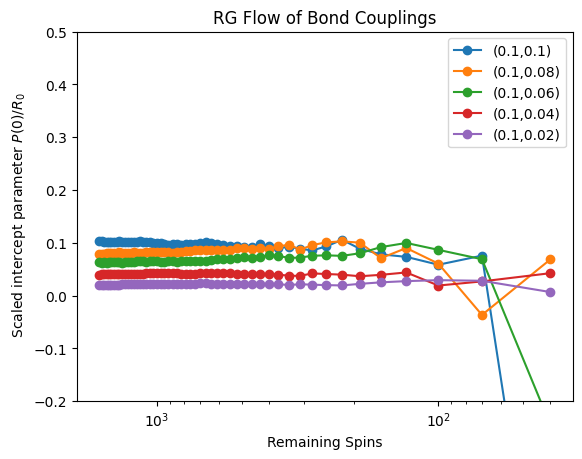

In [120]:
x = L*L - np.arange(1+int(steps/measure_step))*measure_step
for b_ind, b in enumerate(b_vals):
    y = b_list[b_ind,:]*9/R0_array[b_ind,:]
    plt.plot(x, y, marker='o', label="("+str(a)+","+str(b)+")")
plt.gca().invert_xaxis()
plt.xscale('log')
plt.ylim(-0.2, 0.5)

plt.title("RG Flow of Bond Couplings")
plt.xlabel("Remaining Spins")
plt.ylabel(r" Scaled slope parameter $P(0)/R_0$")

plt.legend()

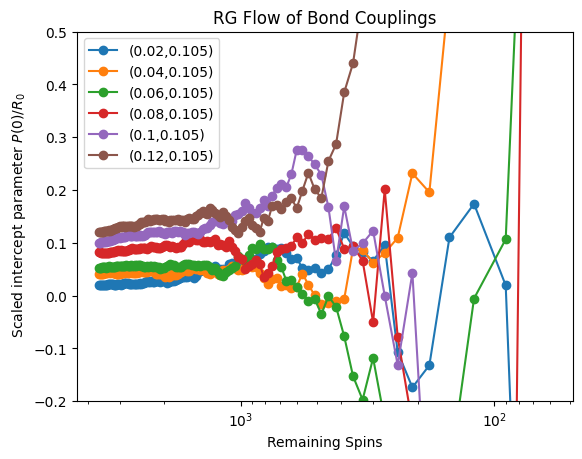

In [144]:
x = L*L - np.arange(1+int(steps/measure_step))*measure_step
for a_ind, a in enumerate(a_vals):
    y = a_list[a_ind,:]*9/R0_array[a_ind,:]
    plt.plot(x, y, marker='o', label="("+str(a)+","+str(b)+")")
plt.gca().invert_xaxis()
plt.xscale('log')
plt.ylim(-0.2, 0.5)

plt.title("RG Flow of Bond Couplings")
plt.xlabel("Remaining Spins")
plt.ylabel(r" Scaled intercept parameter $P(0)/R_0$")

plt.legend()

[0.11997526 2.66944172]
0.23995051795958755


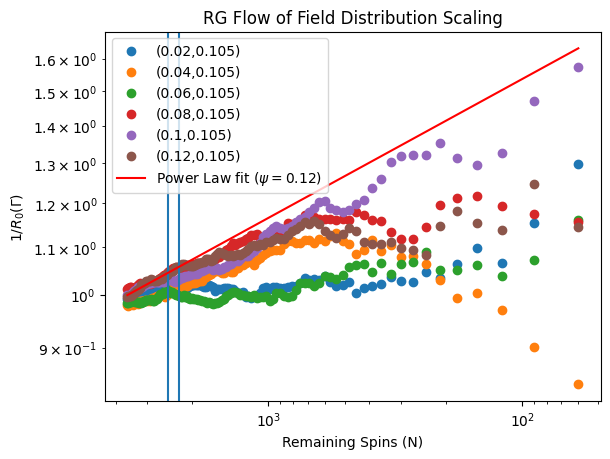

In [146]:
x = L*L - np.arange(1+int(steps/measure_step))*measure_step

R_length = len(y)

start = 37
end = 45

plt.axvline(x = x[start])
plt.axvline(x = x[end])

for a_ind, a in enumerate(a_vals):
    y = runs/R0_array[a_ind,:]
    plt.scatter(x, y, label="("+str(a)+","+str(b)+")")#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)


#plt.yscale('log')

popt, pcov = curve_fit(power_law_scale, x[start:end], y[start:end])
print(popt)
print(popt[0]*2)

plt.title("RG Flow of Field Distribution Scaling")
plt.xlabel("Remaining Spins (N)")
plt.ylabel(r"$1/R_0(\Gamma)$")
plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Power Law fit ($\psi=$'+str(round(popt[0], 4))+')')

plt.gca().invert_xaxis()
plt.legend()
plt.yscale('log')
plt.xscale('log')

#plt.xlim(1e4, 0.8*1e3)

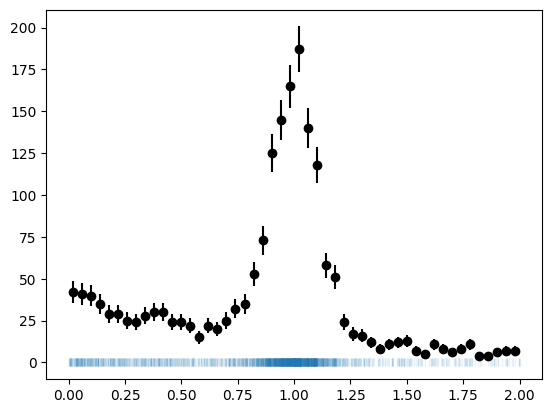

In [103]:
xr = (0, 2)  # xrange

rng = np.random.default_rng(1)

xdata = rng.normal(1, 0.1, size=1000)
ydata = rng.exponential(size=len(xdata))
xmix = np.append(xdata, ydata)
xmix = xmix[(xr[0] < xmix) & (xmix < xr[1])]

n, xe = np.histogram(xmix, bins=50, range=xr)
cx = 0.5 * (xe[1:] + xe[:-1])
dx = np.diff(xe)

plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.plot(xmix, np.zeros_like(xmix), "|", alpha=0.1);

In [104]:
def pdf(x, z, mu, sigma, tau):
    return (z * truncnorm.pdf(x, *xr, mu, sigma) +
            (1 - z) * truncexpon.pdf(x, *xr, 0.0, tau))

c = cost.UnbinnedNLL(xmix, pdf)

m = Minuit(c, z=0.4, mu=0.1, sigma=0.2, tau=2)
m.limits["z"] = (0, 1)
m.limits["sigma", "tau"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 768.1                      │              Nfcn = 553              │
│ EDM = 7.71e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.537   │   0.015   │            │            │    0    │    1    │       │
│ 1 │ mu    │   0.996   │   0.004   │            │            │         │         │       │
│ 2 │ sigma │  0.1006   │  0.0035   │            │            │    0    │         │       │
│ 3 │ tau   │   1.05    │   0.08    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │         z        mu     sigma       tau │
├───────┼─────────────────────────────────────────┤
│     z │  0.000231 -3.05e-06   1.9e-05 -0.000236 │
│    mu │ -3.05e-06   1.5e-05  -9.5e-07 -1.54e-05 │
│ sigma │   1.9e-05  -9.5e-07  1.25e-05 -4.35e-05 │
│   tau │ -0.000236 -1.54e-05 -4.35e-05   0.00568 │
└───────┴─────────────────────────────────────────┘

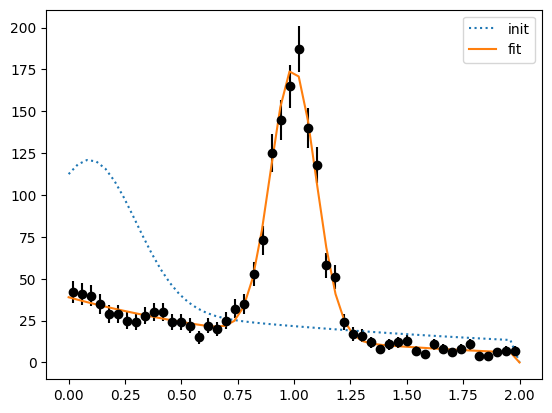

In [105]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
xm = np.linspace(*xr)
plt.plot(xm, pdf(xm, *[p.value for p in m.init_params]) * len(xmix) * dx[0],
         ls=":", label="init")
plt.plot(xm, pdf(xm, *m.values) * len(xmix) * dx[0], label="fit")
plt.legend();

In [142]:
h_remain = test.h_vals
h_remain = h_remain[h_remain!=0]

c = cost.UnbinnedNLL(-np.log(h_remain/test.Omega), exponential_dist_norm)
m = Minuit(c, a=0.8)
m.limits["a"] = (0.5, 1)
#m.limits["sigma", "tau"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 324.6                      │              Nfcn = 20               │
│ EDM = 2.17e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.74    │   0.07    │            │            │   0.5   │    1    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────┐
│   │      a │
├───┼────────┤
│ a │ 0.0044 │
└───┴────────┘

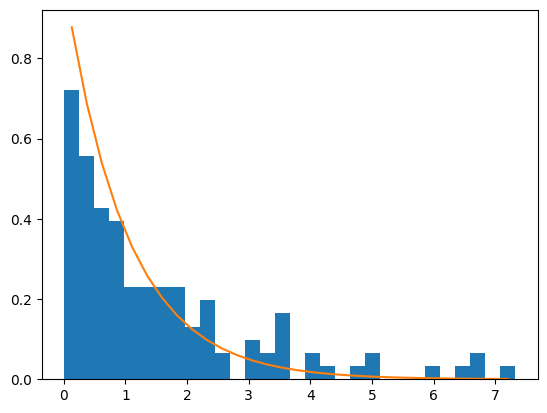

In [116]:
n,bins,patches = plt.hist(-np.log(h_remain/test.Omega), density=True, bins = 30)
width = bins[1]-bins[0]

plt.plot((bins[1:]-width/2), exponential_dist_norm((bins[1:]-width/2), *m.values))

In [112]:
def cdf(x, a):
    return (z * truncnorm.cdf(xe, *xr, mu, sigma) +
            (1-z) * truncexpon.cdf(xe, *xr, 0, tau))

c = cost.BinnedNLL(n, xe, cdf)
m = Minuit(c, z=0.4, mu=0, sigma=0.2, tau=2)
m.limits["z"] = (0, 1)
m.limits["sigma", "tau"] = (0, None)
m.migrad()

<ValueView a=51.72759242081264>